In [4]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from iminuit import Minuit, cost

In [5]:
col = ['1/Q','1/Q_err','T']
data = pd.read_csv('Fitted.csv',delimiter='\t',usecols=col)
#data = data.to_dict()
#data = Namespace(x=np.array(data['T']), y=np.array(data['1/Q']), y_err=np.array(data['1/Q_err']))

In [6]:
x = np.array(data['T'],dtype=float)
y = np.array(data['1/Q'],dtype=float)
yerr = np.array(data['1/Q_err'],dtype=float)

In [7]:
KB = c.Boltzmann
hbar = c.Planck

In [8]:
omega=3.17*1e9
alpha = 0.8
#q0 = (1/3.75)*1e5

In [9]:
def D(x,y):
    der = np.zeros(len(x))
    for i in range(len(x)-1):
        n = y[i+1] - y[i]
        d = x[i+1] - x[i]
        der[i] = n/d
    return der 

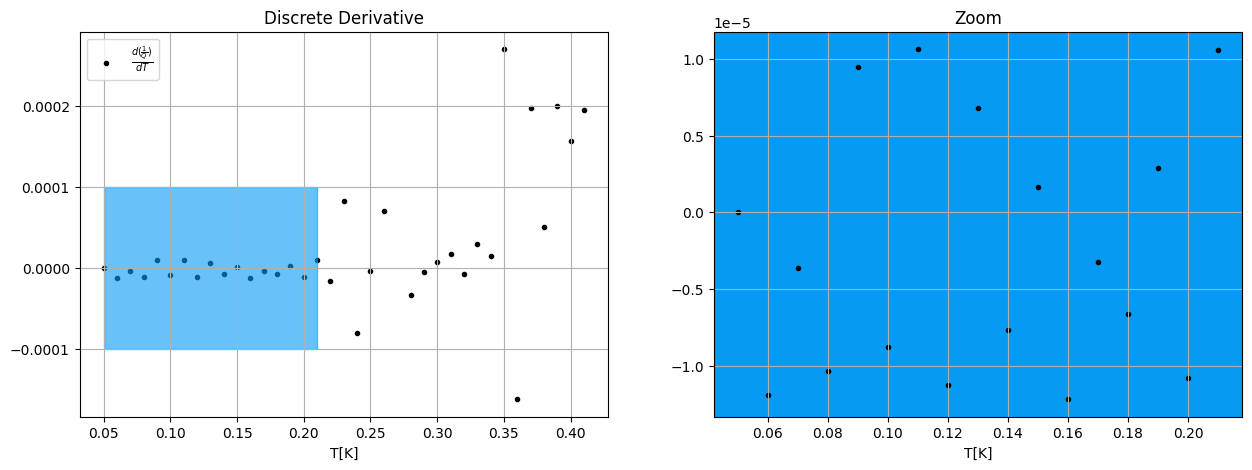

In [10]:
der = D(x,y)

fig, ax = plt.subplots(1,2, sharex=False, sharey=False, figsize=(15,5))
ax[0].scatter(x,D(x,y),marker='.',label=r'$\frac{d(\frac{1}{Q})}{dT}$',color='black')
ax[1].scatter(x[np.where(x<0.22)],D(x[np.where(x<0.22)],y[np.where(x<0.22)]),marker='.',label=r'$\frac{d(\frac{1}{Q})}{dT}$',color='black')
ax[0].set_xlabel('T[K]')
ax[1].set_xlabel('T[K]')
ax[0].set_title('Discrete Derivative')
ax[1].set_title('Zoom')
ax[0].legend(loc='upper left')
#plt.axhline(threshold, color='green', lw=2, alpha=0.7)
ax[0].fill_between(x, -0.0001, 0.0001, where=x<0.22, color='#069AF3',alpha=0.6)
ax[1].set_facecolor('#069AF3')
ax[0].grid()
ax[1].grid()

Dire che possiamo usare i punti a $T<0.22K$ per trovare una stima iniziale del parametro $Q_{0}$

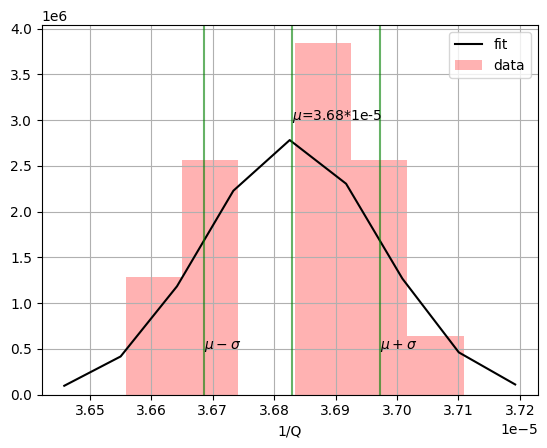

In [11]:
from scipy.stats import norm
import statistics
   
idx = np.where(x<0.22)
datas = y[idx]
step = (max(datas) - min(datas))/6
x_axis = np.arange(min(datas)-1e-7, max(datas)+1e-7, step)
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
mu, std = norm.fit(datas)
dist = norm.pdf(x_axis, mu, std)
plt.plot(x_axis, norm.pdf(x_axis, mu, std),color='black',label='fit')
plt.hist(datas, bins='auto', density=True, alpha=0.3, color='red',label='data')
plt.axvline(x=mu, color='green', alpha=0.6)
plt.axvline(x=mu+std, color='green', alpha=0.6)
plt.axvline(x=mu-std, color='green', alpha=0.6)
plt.text(mu , 3*1e6, r'$\mu$'+'='+f'{mu*1e5:.2f}*1e-5')
plt.text(mu+std, 0.5*1e6, r'$\mu+\sigma$')
plt.text(mu-std, 0.5*1e6, r'$\mu-\sigma$')
plt.xlabel('1/Q')
plt.grid()
plt.legend()

In [13]:
q0=1/mu
print(q0)

27152.40199827441


Non è un gran fit...però la stima di $Q_{0}$ sembra ragionevole...

In [ ]:
def QT(T,d0):
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0

def kondo(T, d0, b, T_k):
    omega=3.17*1e9
    alpha = 0.8
    q0 = (1/3.75)*1e5
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + 1/q0 - b*np.log(T/T_k)

Parametri iniziali

In [ ]:
d0 = 4.8*1e-23
b= 1e-7
T_k = 0.3

In [75]:
lsq = cost.LeastSquares(x, y, yerr, kondo)
m_kondo = Minuit(lsq, d0=d0, b=b, T_k=T_k)

In [77]:
m_kondo.migrad(ncall=10000);

TypeError: Cost.__call__() got an unexpected keyword argument 'd0'

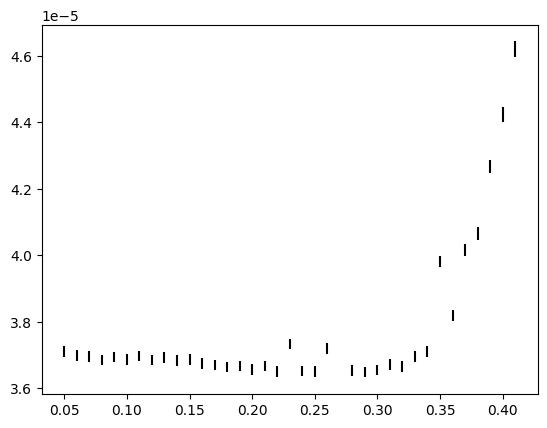

In [ ]:
plt.errorbar(x,y,xerr=0,yerr=yerr,alpha=1, color='black',label='Q-fits',marker='.',fmt='none')
plt.plot(x,kondo(x,d0=m_kondo.values[0],b=m_kondo.values[1],T_k=m_kondo.values[2]),marker='.',label='KONDO fit')#,label='KONDO-fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(m_kondo.values))
#plt.plot(x,QT(T=x,d0=m_no_kondo.values[0]),marker='.',label='NO-KONDO fit')#,label='KONDO-fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(m_kondo.values))
plt.ylabel('1/Q')
plt.xlabel('T[K]')
textstr = '\n'.join((
    #r"No-KONDO: $\chi_{0}^2$ ="+f"{chi2_0_nk:.1f}",
    r"$\Delta_{0}$ ="+f"({m_no_kondo.values[0]*1e23:.2f} ",#+r"$\pm$"+f"{np.sqrt(np.diag(pcov_nk)[0])*1e23:.2f})"+r"$\times$ $10^{-23}$",
    r"==================",
    r"KONDO:    $\chi_{0}^2$ ="#+f"{chi2_0:.1f}",
    r"$\Delta_{0}$ ="+f"({m_kondo.values[0]*1e23:.2f} "+r"$\pm$",#+f"{np.sqrt(np.diag(pcov)[0])*1e23:.2f})"+r"$\times$ $10^{-23}$"+" J",
    r"$T_{KONDO}$ ="+f"({m_kondo.values[2]*1e3:.1f}"+r"$\pm$",#+f"{np.sqrt(np.diag(pcov)[2])*1e3:.6f})"+r"$\times$ $10^{-3}$"+" K",
    r"$b$ ="+f"({m_kondo.values[1]*1e7:.1f}"+r"$\pm$")#+f"{np.sqrt(np.diag(pcov)[1])*1e7:.6f})"+r"$\times$ $10^{-7}$")
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.045, 4.4*1e-5, textstr, fontsize=10,verticalalignment='top', bbox=props)
plt.legend(loc='upper left')
plt.title(r'$\frac{1}{Q}$ vs T')
plt.grid()

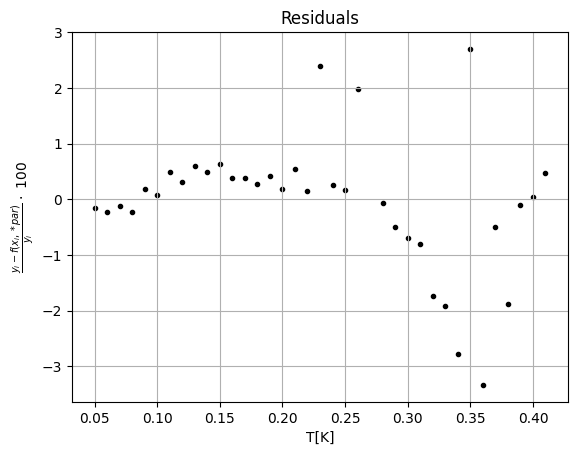

In [607]:
plt.scatter(x,(y-kondo(T=x,d0=popt[0],b=popt[1],T_k=popt[2]))/y * 100,marker='.',label='Residuals',color='black')
plt.xlabel('T[K]')
plt.title('Residuals')
plt.ylabel(r'$\frac{y_{i}-f(x_{i},*par)}{y_{i}}\cdot$ 100')
plt.grid()